# PV3 - 01 - HTW Weather Data

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>
__copyright__ 	= "© Reiner Lemoine Institut" <br>

Access the sonnja database and visualise the weather data

# Imports

In [1]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v0.0.1'
project = 'pv3'

# Database Connection

In [2]:
def postgres_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = 'localhost' # input('host (default 130.226.55.43): ')
    port = '5435' # input('port (default 5432): ')
    database = 'sonnja_db' # input("database name (default 'reeem'): ")
    user = 'sonnja' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()

C:\Users\Lody\AppData\Local\Temp\ipykernel_3572\1604365305.py:11: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Data Analysis

## Select table metadata

This section can be used to get the metadata from one database table.<br>
The result is printed.<br>

In [3]:
# Database select (SQL)
sql = text("""SELECT obj_description('pv3.htw_weatherdata_2015'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']
print(meta_str)

{
    "name": "pv3.htw_weatherdata_2015",
    "title": "HTW Weatherdata",
    "id": null,
    "description": "HTW Weatherdata 2015",
    "language": [
        "en-GB",
		"de-DE"
    ],
    "keywords": [
        "weatherdata"
    ],
    "publicationDate": null,
    "context": {
        "homepage": "https://re-master.htw-berlin.de/",
        "documentation": "Solaranlangen und -kraftwerke (W-PV3)",
        "sourceCode": "https://github.com/htw-pv3/weather-data",
        "contact": "ludwig.huelk@rl-institut.de",
        "grantNo": null,
        "fundingAgency": null,
        "fundingAgencyLogo": null,
        "publisherLogo": "https://corporatedesign.htw-berlin.de/files/Presse/_tmp_/d/5/csm_Bild-Wort-Marke_auf_weiss_1280x853_3722b5420f.jpg"
    },
    "spatial": {
        "location": "Wilhelminenhofstraße 75A, 12459 Berlin",
        "extent": null,
        "resolution": null
    },
    "temporal": {
        "referenceDate": "2015",
        "timeseries": {
            "start": "2015-01-01 

In [4]:
text_name = r'data/htw_weatherdata_2015_metadata.txt'
with open(text_name, "w") as text_file:
    print(meta_str, file=text_file)
print("Metadata saved to file:", text_name)

Metadata saved to file: data/htw_weatherdata_2015_metadata.txt


## Select Weather Data

Requires script: htw_pv3_postgresql_05_setup_tables_and_import_data.sql

In [5]:
# Database select (SQL)
# SELECT  timestamp, g_hor_si, g_gen_cmp11, ev_beleuchtung   -- column
sql = text("""
    SELECT *
    FROM    pv3.htw_weatherdata_2015  -- table
    """)
df = pd.read_sql_query(sql, con)
df = df.set_index('timestamp')

### Plot Weather Data

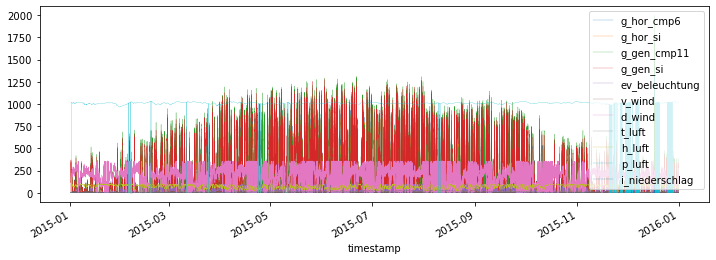

In [6]:
# Plot all columns
ax = df.plot(figsize=(12, 4), lw=0.25)

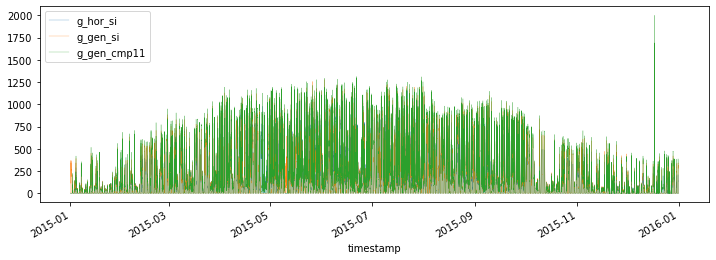

In [7]:
# Plot irradiation
df_ir = df[['g_hor_si','g_gen_si', 'g_gen_cmp11']]
ax = df_ir.plot(figsize=(12, 4), lw=0.25)

### Resample to 1 hour

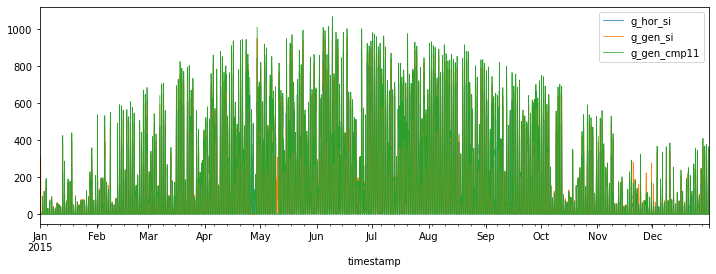

In [8]:
df_reH = df_ir.resample('1H').mean()
ax = df_reH.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 day

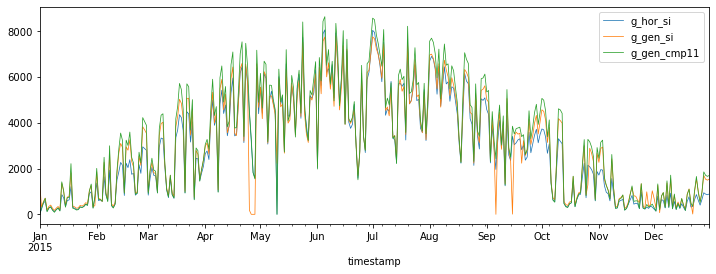

In [9]:
df_reD = df_reH.resample('1D').sum()
ax = df_reD.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 month

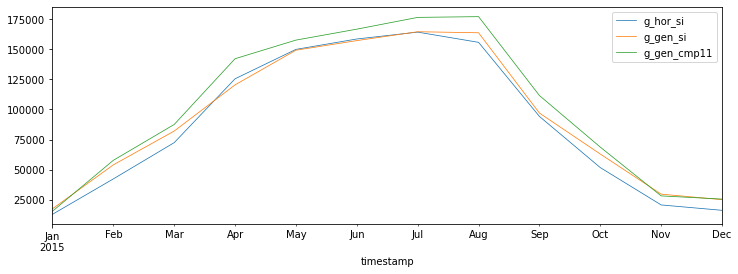

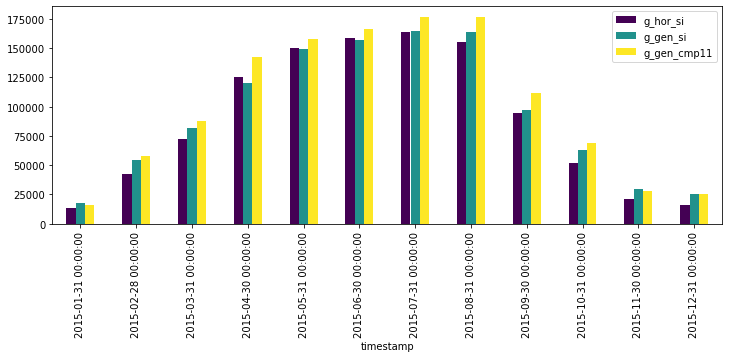

In [10]:
df_reM = df_reD.resample('1M').sum()
ax = df_reM.plot(figsize=(12, 4), lw=0.75)
ax = df_reM.plot.bar(figsize=(12, 4), stacked=False, colormap='viridis')

# Metadata

The important information from the above select (**df**) is collected in a Dictionary (**info_dict**).

In [11]:
# Facts dict
info_dict = {}
info_dict['Filename'] = ['{}_pv3_htw_weather_data'.format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Globalstrahlung (G)']
info_dict['Unit'] = ['W/m²']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Stunde im Jahr']
info_dict['Title'] = ['HTW Weather Data']
info_dict['Metadata'] = [meta_str]

# Print facts
# for x in info_dict:
#     print(x,':',info_dict[x])

## Plot with Metadata

(0.0, 1121.904)

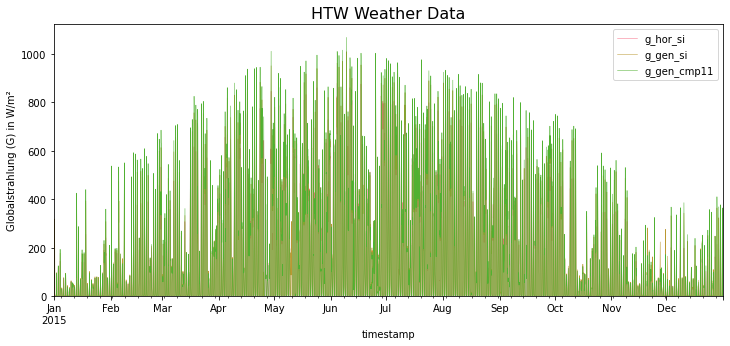

In [12]:
sns.set_palette("husl")
mfig_weather = plt.figure(figsize=(12, 5))
ax = plt.subplot()
plt.title(*info_dict['Title'], fontsize=16)         # Title from info
plt.ylabel(*info_dict['Y-Axis'])                    # Label from info
df_ir.resample('1H').mean().plot(ax=ax, lw=0.5, markeredgewidth=3)
ax.set_ylim(ymin=0)

## Interactive Plot with Metadata

In [13]:
# Interactive plot
data = [
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['g_hor_si'].tolist(), 
               name='G hor Si', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['g_gen_si'].tolist(), 
               name='G gen Si', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['g_gen_cmp11'].tolist(), 
               name='G gen CMP11', line=dict(), mode='lines'),
]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig_weather = go.Figure(data=data, layout=layout)
pltly.iplot(ifig_weather)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [14]:
# Write facts to textfile
txtname = ('data/{}.txt').format(*info_dict['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = 'data/{}_df_reH.csv' .format(*info_dict['Filename'])
df_reH.to_csv(csvname, sep=';', decimal=',')
print("Data saved to file:", csvname)

csvname = 'data/{}_df_reD.csv' .format(*info_dict['Filename'])
df_reD.to_csv(csvname, sep=';', decimal=',')
print("Data saved to file:", csvname)

csvname = 'data/{}_df_reM.csv' .format(*info_dict['Filename'])
df_reM.to_csv(csvname, sep=';', decimal=',')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}_mfig_weather.png' .format(*info_dict['Filename'])
mfig_weather.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plots
htmlname = 'data/{}_ifig_weather.html' .format(*info_dict['Filename'])
pltly.plot(ifig_weather, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/2022-05-22_pv3_htw_weather_data.txt
Data saved to file: data/2022-05-22_pv3_htw_weather_data_df_reH.csv
Data saved to file: data/2022-05-22_pv3_htw_weather_data_df_reD.csv
Data saved to file: data/2022-05-22_pv3_htw_weather_data_df_reM.csv
Plot saved to file: data/2022-05-22_pv3_htw_weather_data_mfig_weather.png
Interactive plot saved to file: data/2022-05-22_pv3_htw_weather_data_ifig_weather.html
